<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/CaseWithMean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install "git+https://github.com/Karasiari/HuGraphFinal.git"

  Cloning https://github.com/Karasiari/HuGraphFinal.git to /tmp/pip-req-build-ic3k7q9m
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/HuGraphFinal.git /tmp/pip-req-build-ic3k7q9m
  Resolved https://github.com/Karasiari/HuGraphFinal.git to commit 5ae64a65805a00441d144f26bd599ba05ed8ebd8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hugraphfin: filename=hugraphfin-0.1.0-py3-none-any.whl size=65926 sha256=49a14e174791fc6167370734f3da2b0aecc65d0cd4611e438e0d52ce2f89b433
  Stored in directory: /tmp/pip-ephem-wheel-cache-61f20pmo/wheels/46/83/89/572a6db8e6320eb877bf6ced236fa61f993538a12c5e43c72e
Successfully built hugraphfin


In [54]:
# чтобы не падал ecos
%pip install ecos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 5.3 MB/s eta 0:00:00


In [52]:
from graph_exps.traffic_generation.generation_for_exp import generate_own_traffic
from graph_exps.SNRBA_generation.generation import generate_snr_ba_graph

import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Список для хранения всех DataFrame
all_dfs = []

def small_test_table(num_tests: int):
  available_demand_volumes = ((1, 0.9), (2, 0.1))
  capacity_value = 80.0

  additional_resources = [capacity_value] * 3
  allocation_types = ['alpha', 'random_alpha', 'random']
  additional_resources.sort(reverse=True)
  result_dict = {}
  for i in range(num_tests):
    snr_ba_graph = generate_snr_ba_graph(num_nodes=25, capacity_value=capacity_value, random_seed=42+i)

    adj_graph_alpha, traffic_graph_alpha =  generate_own_traffic(
    snr_ba_graph,
    available_demand_volumes,
    generation_type="alpha_with_sa",
    generation_params={"alpha_target": 0.35, "epsilon": 0.025, "median_weight_for_initial": 20, "var_for_initial": 1, "multi_max": 5, "t": 0.5}
    )
    graph_for_exp_alpha = HuGraphForExps(adj_graph_alpha, traffic_graph_alpha)

    results_alpha = expand_test_for_graph(
        graph=graph_for_exp_alpha,
        additional_resources=additional_resources,
        allocation_types=allocation_types,
        tries_for_allocation=15,
        epsilon=1.2,
        available_volumes=available_demand_volumes
    )
    df = results_alpha
    df['experiment'] = f'exp_{i}'
    df['type'] = df.index.get_level_values(0)
    all_dfs.append(df.copy())

In [ ]:
small_test_table(10)

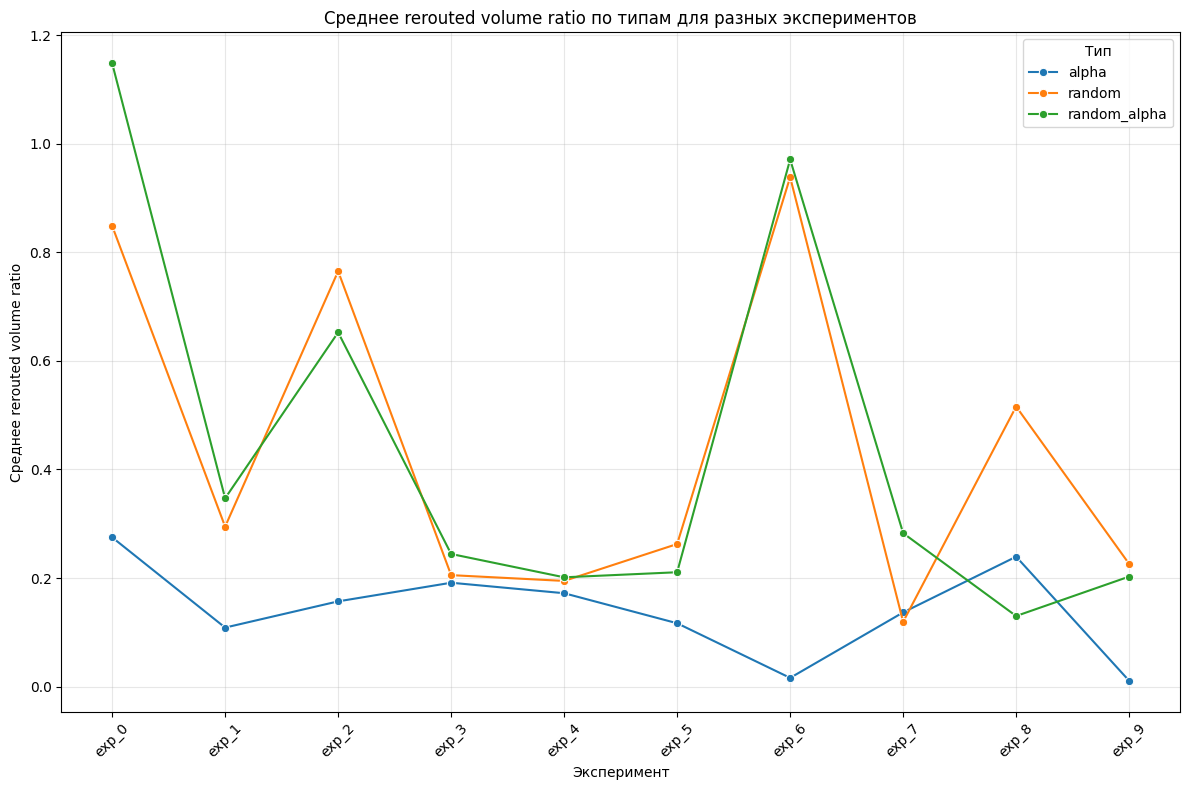

In [56]:
# Объединяем все DataFrame
combined_df = pd.concat(all_dfs, ignore_index=False)

# Считаем средние по типам для каждого эксперимента
average_by_type_exp = combined_df.groupby(['experiment', 'type'])['rerouted volume ratio'].mean().reset_index()

# Строим график
plt.figure(figsize=(12, 8))
sns.lineplot(data=average_by_type_exp, x='experiment', y='rerouted volume ratio', hue='type', marker='o')
plt.title('Среднее rerouted volume ratio по типам для разных экспериментов')
plt.xlabel('Эксперимент')
plt.ylabel('Среднее rerouted volume ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='Тип')
plt.tight_layout()
plt.show()

In [51]:
from graph_exps.traffic_generation.generation_for_exp import generate_own_traffic
from graph_exps.SNRBA_generation.generation import generate_snr_ba_graph

def small_test(num_tests: int):
  available_demand_volumes = ((1, 0.9), (2, 0.1))
  capacity_value = 80.0

  additional_resources = [capacity_value] * 3
  allocation_types = ['alpha', 'random_alpha', 'random']
  additional_resources.sort(reverse=True)
  result_dict = {}
  for i in range(num_tests):
    snr_ba_graph = generate_snr_ba_graph(num_nodes=25, capacity_value=capacity_value, random_seed=42+i)

    adj_graph_alpha, traffic_graph_alpha =  generate_own_traffic(
    snr_ba_graph,
    available_demand_volumes,
    generation_type="alpha_with_sa",
    generation_params={"alpha_target": 0.35, "epsilon": 0.025, "median_weight_for_initial": 20, "var_for_initial": 1, "multi_max": 5, "t": 0.5}
    )
    graph_for_exp_alpha = HuGraphForExps(adj_graph_alpha, traffic_graph_alpha)

    graph = graph_for_exp_alpha
    edges_with_alphas = compute_alpha_for_all_edges(graph)
    route_result, demands, _, multidigraph = graph.solve_mcf()
    expanded_graphs = {}
    for allocation_type in allocation_types:
      expanded_graphs[allocation_type] = expand_network_for_type(multidigraph, edges_with_alphas, additional_resources, allocation_type)
    edges_for_remaining_networks = get_edges_for_remaining_networks(expanded_graphs, remaining_networks_pref="all", route_result=route_result, demands=demands)
    allocation_results_raw = allocation_test(expanded_graphs, route_result, demands, edges_for_remaining_networks, tries_for_allocation=10, epsilon=1.2, available_volumes=available_demand_volumes, random_seed=None)
    for allocation_type, result in allocation_results_raw[0]:
      result_dict[allocation_type] = result_dict.get(allocation_type, 0) + result[1]
    print(result_dict, allocation_results_raw[2])